## TESTER NOTEBOOK FOR SEGMENTATION METHODS DONE ON TEST IMAGES

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, felzenszwalb, watershed
from skimage.transform import resize
from skimage.color import rgb2hsv
from skimage import morphology

1128000
1143072


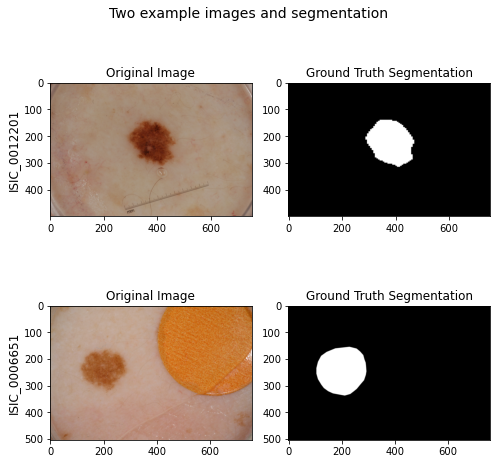

In [2]:
# Setup

def prep_im(im_id):
    '''Read image and corresponding ground truth segmentation from test images

    Args:
        im_id (str): image ID

    Returns:
        im (numpy.ndarray): image
        gt (numpy.ndarray): ground truth segmentation
    '''

    #Read and resize image
    im = plt.imread('example_image/' + im_id + '.jpg')
    im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)

    #Read and resize ground truth segmentation
    gt = plt.imread('example_segmentation/' + im_id + '_segmentation.png')
    gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=True)

    return im, gt

#Two images are chosen, one with an unwanted object to the side and one without
im_id1 = 'ISIC_0012201' #Only lesion
im_id2 = 'ISIC_0006651' #Lesion and big orange circle

im1, gt1 = prep_im(im_id1)
im2, gt2 = prep_im(im_id2)


#Plotting (not necesarry, only done to obtain general overview of images)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

#Titles and labels
fig.suptitle('Two example images and segmentation', size=14)
axes[0, 0].set_title('Original Image')
axes[0, 1].set_title('Ground Truth Segmentation')
axes[1, 0].set_title('Original Image')
axes[1, 1].set_title('Ground Truth Segmentation')
axes[0, 0].set_ylabel(im_id1, rotation=90, size='large')
axes[1, 0].set_ylabel(im_id2, rotation=90, size='large')

#Plots
axes[0, 0].imshow(im1)
axes[0, 1].imshow(gt1, cmap='gray')
axes[1, 0].imshow(im2)
axes[1, 1].imshow(gt2, cmap='gray')

print(im1.size)
print(im2.size)
fig.tight_layout()

### 1. SLIC (superpixel segmentation)

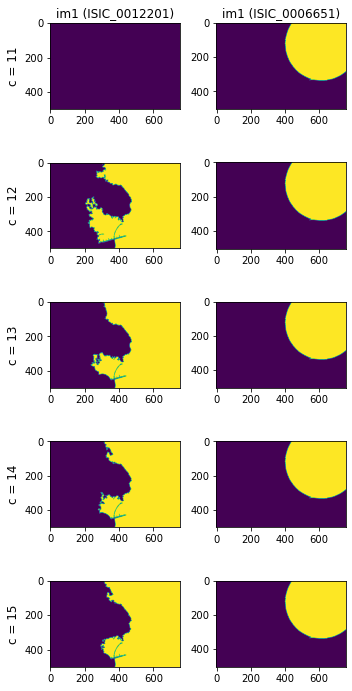

In [5]:
#Compactness coefficient c used in slic, a value we need to refine in eventual final implementation.
#Balances color proximity vs space proximity, high values will make superpixel shapes more squares, 
#and should most likely be avoided as square lesions are rarely.
#Documentation recomends initially balancing compactness on log_10 scale, i.e., .01, .1, 1, 10, 100. 
#See more at https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

c = 10
s = 3 #Amount of max segments

#im1_segments = slic(im1, n_segments=s, compactness=c)
#im2_segments = slic(im2, n_segments=s, compactness=c)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5, 10))
axes[0, 0].set_title(f'im1 ({im_id1})')
axes[0, 1].set_title(f'im1 ({im_id2})')

#Trying different values for c
c_vals = [11, 12, 13, 14, 15] #Best working c values I could get
for i in range(5):
    c = c_vals[i]
    axes[i, 0].set_ylabel(f'c = {c}', rotation=90, size='large')
    axes[i, 0].imshow(slic(im1, n_segments=s, compactness=c))
    axes[i, 1].imshow(slic(im2, n_segments=s, compactness=c))

fig.tight_layout()

#Conclusion: Even with custom precision in c, this does NOT work well for our use

### 2. Felzenszwalb (buttom-up segmentation)

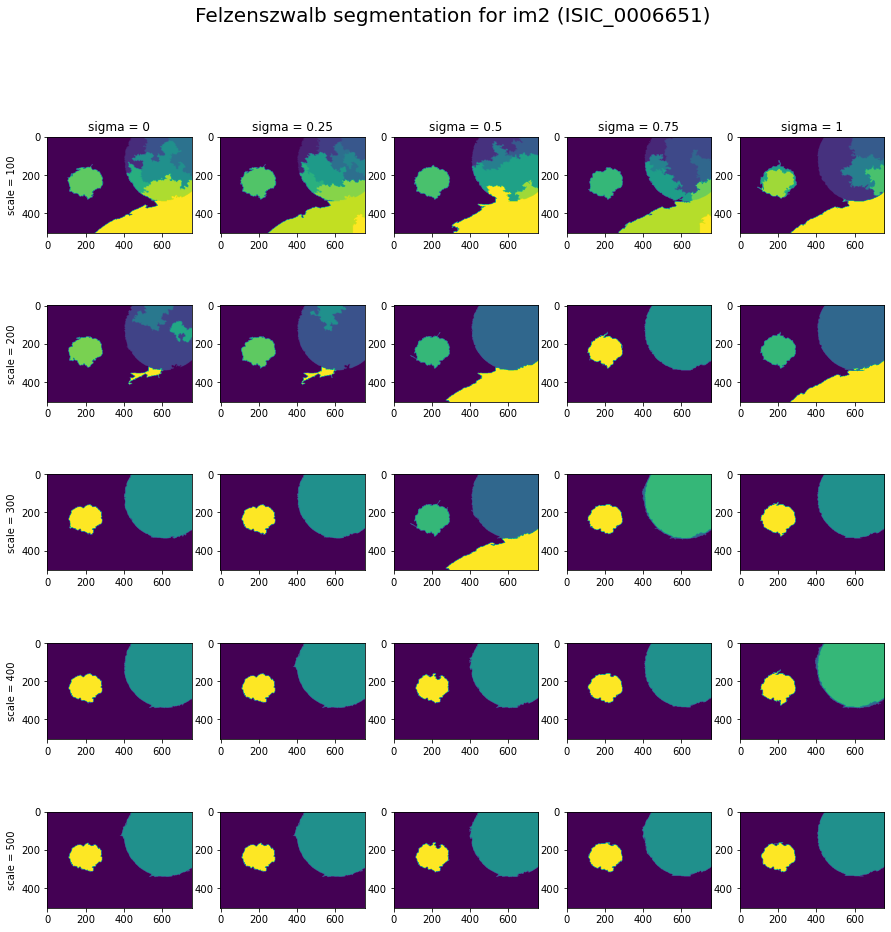

In [53]:
def fzw(image, scale, sigma):
    '''Performs the Felzenszwalb segmentation algorithm on an image

    Args:
        image (numpy.ndarray): image to segment
        scale (float): controls the observation lever, higher values gives fewer but larger segments 
        sigma (float): the diameter of a Gaussian smoothing kernel, higher values equals higher degree of smoothing
    
        Returns:
            segments (numpy.ndarray): segmentated image.
    '''
    
    segments = felzenszwalb(image, 
                           scale=scale, 
                           sigma=sigma,
                           min_size=image.size // 300,
                           channel_axis=2
                           )
    return segments

scale_vals = [100, 200, 300, 400, 500]
sigma_vals = [0, .25, .5, .75, 1]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
fig.suptitle(f'Felzenszwalb segmentation for im2 ({im_id2})', size=20)

for i in range(5):
    scale = scale_vals[i]
    axes[i, 0].set_ylabel(f'scale = {scale}')
    for j in range(5):
        sigma = sigma_vals[j]
        segments = fzw(im2, scale, sigma)
        axes[i, j].imshow(segments)
        if i == 0:
            axes[i, j].set_title(f'sigma = {sigma}')

#Conclusion: seems to produce good results with right parameters
#We still need a method to remove the big brightly colored non-lesion objects

### Possible next step: try to create mask from Felzenszwalb segmentation